# Objetivo:

    Utilizando os dados tratados anteriormoente, desenvolver um modelo de classificação que seja eficiente para identificar quando o empréstimo for de risco ou não.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
url='https://raw.githubusercontent.com/robertferro/analisando_risco_credito/main/1-%20Tratamento%20de%20dados%20(ETL)/dados_analise_risco_de_cresdito.csv'

df = pd.read_csv(url,sep=',')

df.head()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,tipo_moradia_id,objetivo_emprestimo_id,class_risco_historico_id
0,21,5.0,propria,educacao,1000,11.14,9600,0.10,B,0,2,0,3,1,1
1,25,1.0,hipoteca,saude,5500,12.87,9600,0.57,C,0,3,1,1,5,2
2,23,4.0,alugada,saude,35000,15.23,65500,0.53,C,0,2,1,0,5,2
3,24,8.0,alugada,saude,35000,14.27,54400,0.55,C,1,4,1,0,5,2
4,21,2.0,propria,risco,2500,7.14,9900,0.25,A,0,2,1,3,4,0


In [7]:
df.describe()

,idade,tempo_de_emprego,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,tipo_moradia_id,objetivo_emprestimo_id,class_risco_historico_id
count,31679.000000,31679.000000,31679.000000,31679.000000,3.167900e+04,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000,31679.000000
mean,27.730673,4.782064,9659.962436,11.037008,6.649010e+04,0.169610,0.177657,5.809211,0.215442,0.648190,2.501626,1.226617
std,6.213427,4.034948,6334.360554,3.070182,5.276879e+04,0.106269,0.382230,4.059710,0.411135,0.831427,1.753188,1.168138
min,20.000000,0.000000,500.000000,5.420000,4.000000e+03,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,2.000000,5000.000000,8.490000,3.936600e+04,0.090000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000
50%,26.000000,4.000000,8000.000000,11.011695,5.600000e+04,0.150000,0.000000,4.000000,0.000000,0.000000,2.000000,1.000000
75%,30.000000,7.000000,12500.000000,13.160000,8.000000e+04,0.230000,0.000000,8.000000,0.000000,1.000000,4.000000,2.000000
max,94.000000,41.000000,35000.000000,23.220000,2.039784e+06,0.830000,1.000000,30.000000,1.000000,3.000000,5.000000,6.000000


In [8]:
# Estabelecendo um filtro com relação a renda para remover outliers

df=df[df['renda_por_ano']<250000]


# Pré-processamento

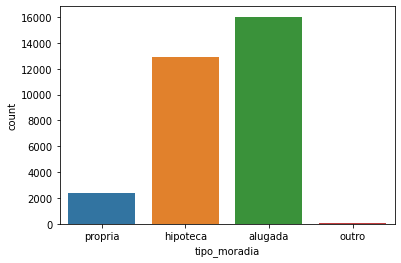

In [9]:
sns.countplot(x='tipo_moradia',data=df)

In [10]:
dados=df.copy()
for col in dados.columns:
    if "_id" in col:
        dados.drop(col,axis=1,inplace=True)

# Criando dicionarios para as variáveis categóricas


dic_tipo_moradia={'propria':0, 'hipoteca':1, 'alugada':2, 'outro':(np.nan)}
dados['tipo_moradia'] = dados['tipo_moradia'].map(dic_tipo_moradia)

dic_objetivo_emprestimo={'educacao':0, 'saude':1, 'risco':2, 'pessoal':3, 'reformar_casa':4,'consolidacao_debito':5}
dados['objetivo_emprestimo'] = dados['objetivo_emprestimo'].map(dic_objetivo_emprestimo)

dic_class_risco_historico={'A':0,'B':1,'C':2,'D':3,'E':(np.nan),'F':(np.nan),'G':(np.nan)}
dados['class_risco_historico'] = dados['class_risco_historico'].map(dic_class_risco_historico)        

dados=dados.dropna()
dados.head()

# dados=df.copy()
# for col in dados.columns:
#     if "_id" in col:
#         dados.drop(col,axis=1,inplace=True)
# dados=pd.get_dummies(dados)

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo
0,21,5.0,0.0,0,1000,11.14,9600,0.10,1.0,0,2,0
1,25,1.0,1.0,1,5500,12.87,9600,0.57,2.0,0,3,1
2,23,4.0,2.0,1,35000,15.23,65500,0.53,2.0,0,2,1
3,24,8.0,2.0,1,35000,14.27,54400,0.55,2.0,1,4,1
4,21,2.0,0.0,2,2500,7.14,9900,0.25,0.0,0,2,1


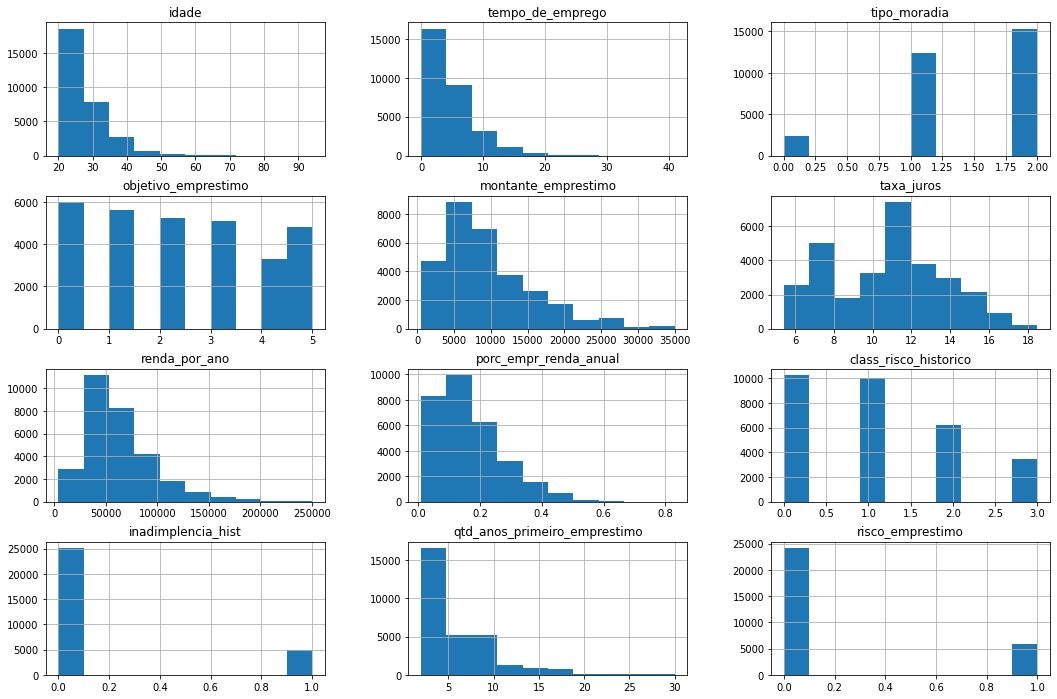

In [11]:
dados.hist(figsize=(18,12));

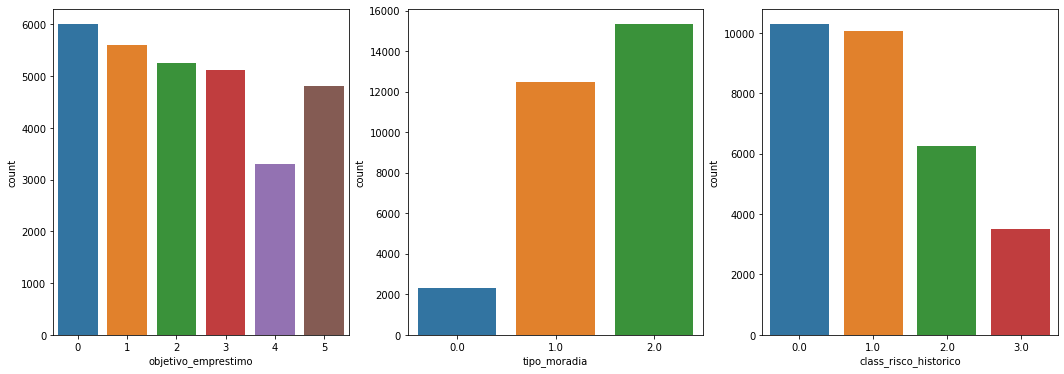

In [12]:
fig,ax=plt.subplots(1,3,figsize=(18,6))

sns.countplot(x='objetivo_emprestimo',data=dados,ax=ax[0]);
sns.countplot(x='tipo_moradia',data=dados,ax=ax[1]);
sns.countplot(x='class_risco_historico',data=dados,ax=ax[2]);


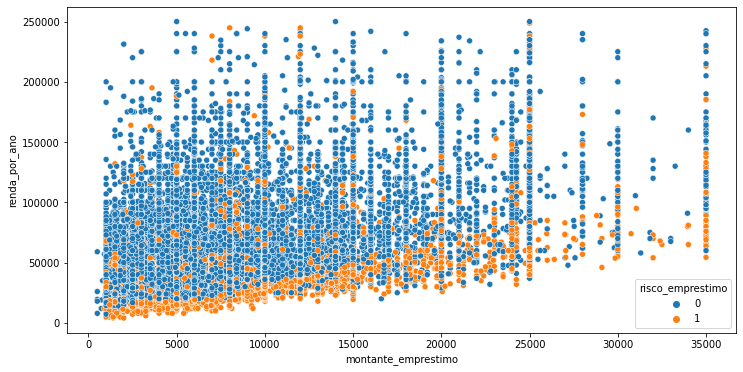

In [13]:
plt.figure(figsize=(12,6))
sns.scatterplot(y='renda_por_ano',x='montante_emprestimo',hue='risco_emprestimo',data=dados);

# Divisão em treino,teste e validação

In [83]:
dados_ml=dados.sample(frac=0.5)
drop=list(dados_ml.index.values)
dados_validacao=dados.drop(drop,axis=0)

In [84]:
# #  Balanceando os dados
# sem_risco = dados_ml[dados_ml['risco_emprestimo']==0].sample(n=4000)
# com_risco = dados_ml[dados_ml['risco_emprestimo']==1]

# df_final = pd.concat([sem_risco,com_risco],axis=0)

# df_final.risco_emprestimo.value_counts()

In [86]:
X=dados_ml.drop(columns='risco_emprestimo',axis=1)
y=dados_ml['risco_emprestimo']



from sklearn.model_selection import train_test_split

X_treino, X_teste, Y_treino, Y_teste = train_test_split(X,y, test_size=0.2,shuffle=True,stratify=y)

# Machine learning

- Benchmark

A acurácia do dummy mostfrequent foi 80.37%
0.5
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2419
           1       0.00      0.00      0.00       591

    accuracy                           0.80      3010
   macro avg       0.40      0.50      0.45      3010
weighted avg       0.65      0.80      0.72      3010



Text(33.0, 0.5, 'Real ( 1 ou 0)')

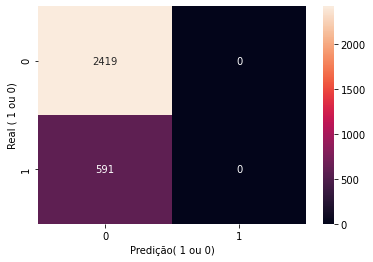

In [87]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_treino, Y_treino)
y_pred = dummy_clf.predict(X_teste)
acuracia = dummy_clf.score(X_teste, Y_teste) * 100

print('A acurácia do dummy mostfrequent foi %.2f%%' % acuracia)

from sklearn.metrics import  roc_auc_score,roc_curve, classification_report,confusion_matrix
from sklearn import metrics

y_proba = dummy_clf.predict_proba(X_teste)

print(roc_auc_score(Y_teste, y_proba[:,1]))
print(classification_report(Y_teste, y_pred))


cm=confusion_matrix(Y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')

- Testando alguns modelos e fazendo também a validação cruzada.

In [88]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



from sklearn.model_selection import cross_val_score

lista_classificacores = [ LogisticRegression(),
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         RandomForestClassifier(),
                         LGBMClassifier(),
                         XGBClassifier()]


for clf in lista_classificacores:
  print(clf.__class__.__name__)
  clf.fit(X_treino, Y_treino)
  train_acc = clf.score(X_treino, Y_treino)
  val_score = cross_val_score(clf, X_treino, Y_treino, cv=5)
  test_acc = clf.score(X_teste, Y_teste)
  print('Treino:', train_acc)
  print('Validation score', val_score.mean())
  print('Teste:', test_acc)

  print('ROC AUC')

  y_proba_treino = clf.predict_proba(X_treino)
  roc_treino = roc_auc_score(Y_treino, y_proba_treino[:, 1])
  print('Treino', roc_treino)

  y_proba_teste = clf.predict_proba(X_teste)
  roc_teste = roc_auc_score(Y_teste, y_proba_teste[:, 1])
  print('Test', roc_teste)
  print('='*80)

LogisticRegression
Treino: 0.8232948409072028
Validation score 0.8316853736402823
Teste: 0.8269102990033222
ROC AUC
Treino 0.7657768675869221
Test 0.76425632104553
GaussianNB
Treino: 0.8335964110658802
Validation score 0.8335126851776449
Teste: 0.8292358803986711
ROC AUC
Treino 0.7848508796688306
Test 0.7836123917463902
DecisionTreeClassifier
Treino: 1.0
Validation score 0.885601898946456
Teste: 0.8837209302325582
ROC AUC
Treino 1.0
Test 0.8272817633106211
RandomForestClassifier
Treino: 0.999833845642602
Validation score 0.9332888088037796
Teste: 0.9338870431893688
ROC AUC
Treino 1.0
Test 0.9164419580184788
LGBMClassifier
Treino: 0.94874138074271
Validation score 0.9371930498946182
Teste: 0.9382059800664452
ROC AUC
Treino 0.9890498351373054
Test 0.9335904629802556
XGBClassifier
Treino: 0.9322090221816067
Validation score 0.9307129192678607
Teste: 0.9318936877076412
ROC AUC
Treino 0.9277386351950675
Test 0.9240239950364745


# **XGBClassifier** 

In [89]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score,recall_score



kf = KFold(n_splits=5,random_state=0,shuffle=True)

recall_lista=[]
for i,(tr,ts) in enumerate(kf.split(X)):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
    clf=XGBClassifier(max_depht=15,n_estimator=250,seed=42)
    clf.fit(Xtr,ytr)
    
    y_pred=clf.predict(Xval)

    recall_score_ = recall_score(yval,y_pred)
    recall_lista.append(recall_score_)
    print('Fold: {}'.format(i))
  
    print('Recall Score: {:.4f}'.format(recall_score_))
    print('='*40)

recall_medio=np.mean(recall_lista)
print('Recall médio: {:.4f}'.format(recall_medio))

Fold: 0
Recall Score: 0.6701
Fold: 1
Recall Score: 0.6845
Fold: 2
Recall Score: 0.7279
Fold: 3
Recall Score: 0.6716
Fold: 4
Recall Score: 0.6638
Recall médio: 0.6836


ROC AUC : 0.9126741875006162

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2423
           1       0.96      0.66      0.79       586

    accuracy                           0.93      3009
   macro avg       0.94      0.83      0.87      3009
weighted avg       0.93      0.93      0.92      3009

A acurácia do XGBCLassifier foi 92.92%


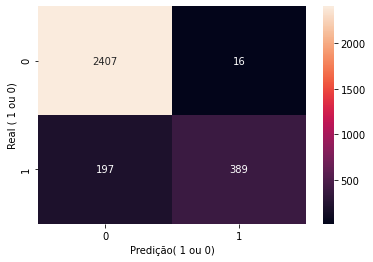

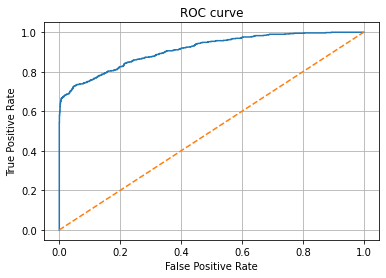

In [90]:
y_proba = clf.predict_proba(Xval)[:,1]
roc_auc = roc_auc_score(yval, y_proba)
print('ROC AUC :',roc_auc)

print()

print(classification_report(yval, y_proba>0.5))


y_pred = clf.predict(Xval)
cm=confusion_matrix(yval, y_proba>0.5)
sns.heatmap(cm, annot=True, fmt='g')


acuracia = clf.score(Xval, yval) * 100
print('A acurácia do XGBCLassifier foi %.2f%%' % acuracia)


plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()



fpr, tpr, thresholds = metrics.roc_curve(yval,y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# **LGBMClassifier**

In [94]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score,recall_score

kf = KFold(n_splits=5,random_state=0,shuffle=True)

recall_lista=[]
for i,(tr,ts) in enumerate(kf.split(X)):
    Xtr, ytr = X.iloc[tr], y.iloc[tr]
    Xval, yval = X.iloc[ts], y.iloc[ts]
    
  
    clf= LGBMClassifier(learning_rate=0.075, n_estimators=1000, num_leaves=100)
    clf.fit(Xtr,ytr)
    
    y_pred=clf.predict(Xval)

    recall_score_ = recall_score(yval,y_pred)
    recall_lista.append(recall_score_)
    print('Fold: {}'.format(i))
  
    print('Recall Score: {:.4f}'.format(recall_score_))
    print('='*40)

recall_medio=np.mean(recall_lista)
print('Recall médio: {:.4f}'.format(recall_medio))

Fold: 0
Recall Score: 0.6997
Fold: 1
Recall Score: 0.7224
Fold: 2
Recall Score: 0.7613
Fold: 3
Recall Score: 0.7010
Fold: 4
Recall Score: 0.6962
Recall médio: 0.7161


ROC AUC : 0.920531200567936

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      2423
           1       0.97      0.70      0.81       586

    accuracy                           0.94      3009
   macro avg       0.95      0.85      0.89      3009
weighted avg       0.94      0.94      0.93      3009

A acurácia do LGBMCLassifier foi 93.72%


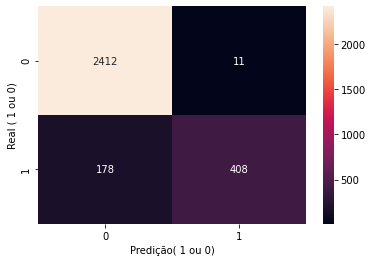

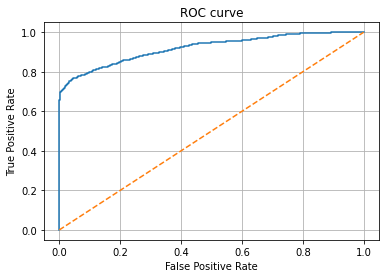

In [95]:
y_proba = clf.predict_proba(Xval)[:,1]
roc_auc = roc_auc_score(yval, y_proba)
print('ROC AUC :',roc_auc)

print()

print(classification_report(yval, y_proba>0.5))


y_pred = clf.predict(Xval)
cm=confusion_matrix(yval, y_proba>0.5)
sns.heatmap(cm, annot=True, fmt='g')
# f1_score_xgb = f1_score(yval,y_pred)
# print('F1 Score do XGBCLassifier foi: {:.4f}'.format(f1_score_xgb))

acuracia = clf.score(Xval, yval) * 100
print('A acurácia do LGBMCLassifier foi %.2f%%' % acuracia)


plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()



fpr, tpr, thresholds = metrics.roc_curve(yval,y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], '--')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# Analisando as previsões

In [96]:
#  criando um novo dataset com os valores reais e as probabilidades
analise = Xval.copy()
analise['risco_emprestimo'] = yval
analise['previsao'] = clf.predict(Xval)
analise['Prob1'] = clf.predict_proba(Xval)[:,1]




analise.tail()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,previsao,Prob1
25672,28,7.0,1.0,3,6000,8.320000,101000,0.06,0.0,0,9,0,0,3.369871e-05
29724,46,18.0,0.0,0,4100,13.490000,60000,0.07,2.0,1,11,0,0,3.435808e-10
4688,23,7.0,1.0,0,7500,8.490000,42500,0.18,0.0,0,3,0,0,1.316529e-04
28777,38,2.0,2.0,2,3000,11.011695,47000,0.06,0.0,0,11,0,0,2.775394e-09
23359,30,14.0,1.0,3,11250,12.210000,69996,0.16,1.0,0,10,0,0,4.242841e-05


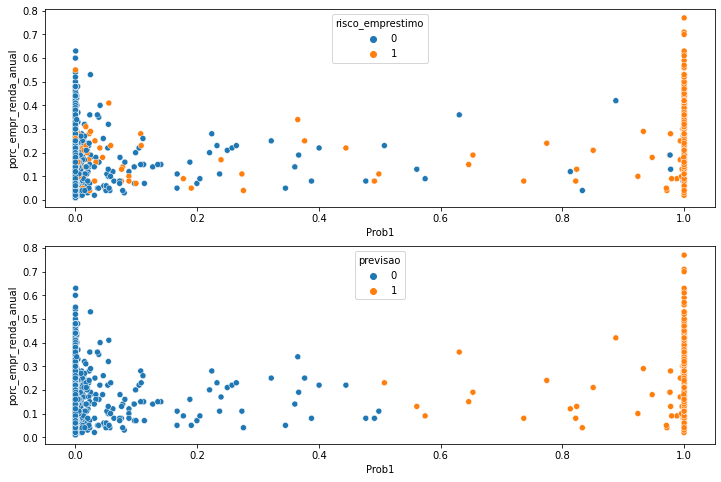

In [97]:
fig,ax=plt.subplots(2,1,figsize=(12,8))
sns.scatterplot(y='porc_empr_renda_anual',x='Prob1',hue='risco_emprestimo',data=analise, ax=ax[0])

sns.scatterplot(y='porc_empr_renda_anual',x='Prob1',hue='previsao',data=analise, ax=ax[1])


# Fazendo as previsões para os dados de validação

Esses dados nunca foram vistos pelo modelo, e simulam uma situação real, onde dados novos são inseridos.

Após aplicar o modelo, irei avaliar sua performance novmente, já que nesse caso tenho a variável target.

Separando os dados de validação em X e y

In [98]:
X_val=dados_validacao.drop(columns='risco_emprestimo',axis=1)
y_val=dados_validacao['risco_emprestimo']

F1 Score do LGBMCLassifier na validação foi: 0.8152
A acurácia do LGBMCLassifier na validação foi 93.63%


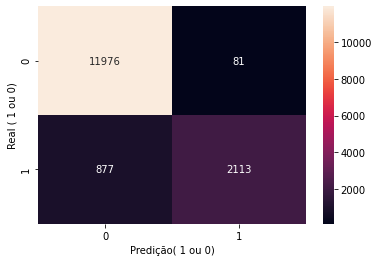


ROC AUC : 0.9310295605350616

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     12057
           1       0.96      0.71      0.82      2990

    accuracy                           0.94     15047
   macro avg       0.95      0.85      0.89     15047
weighted avg       0.94      0.94      0.93     15047



In [99]:
# Ajustando o modelo aos dados de treino e teste
clf.fit(X,y)

# Gerando as previsões
y_pred_validacao=clf.predict(X_val)



cm=confusion_matrix(y_val, y_pred_validacao)
sns.heatmap(cm, annot=True, fmt='g')


f1_score_xgb_validacao=f1_score(y_val,y_pred_validacao)
print('F1 Score do LGBMCLassifier na validação foi: {:.4f}'.format(f1_score_xgb_validacao))
acuracia = clf.score(X_val, y_val) * 100
print('A acurácia do LGBMCLassifier na validação foi %.2f%%' % acuracia)


plt.xlabel('Predição( 1 ou 0)')
plt.ylabel('Real ( 1 ou 0)')
plt.show()

print()

y_proba_validacao = clf.predict_proba(X_val)[:,1]
roc_auc = roc_auc_score(y_val, y_proba_validacao)
print('ROC AUC :',roc_auc)

print()

print(classification_report(y_val, y_proba_validacao>0.5))

In [100]:
analise_validacao = X_val.copy()
analise_validacao['risco_emprestimo'] = y_val
analise_validacao['previsao'] = clf.predict(X_val)
analise_validacao['Prob1'] = clf.predict_proba(X_val)[:,1]



analise_validacao.tail()

,idade,tempo_de_emprego,tipo_moradia,objetivo_emprestimo,montante_emprestimo,taxa_juros,renda_por_ano,porc_empr_renda_anual,class_risco_historico,inadimplencia_hist,qtd_anos_primeiro_emprestimo,risco_emprestimo,previsao,Prob1
31671,56,0.0,1.0,3,7200,6.17,90000,0.08,0.0,0,19,0,0,1.173008e-06
31673,52,0.0,2.0,0,5000,11.26,64500,0.08,1.0,0,20,0,0,9.773481e-02
31676,65,3.0,2.0,4,35000,10.99,76000,0.46,1.0,0,28,1,1,9.999684e-01
31677,56,5.0,1.0,3,15000,11.48,150000,0.10,1.0,0,26,0,0,4.818924e-05
31678,66,2.0,2.0,1,6475,9.99,42000,0.15,1.0,0,30,0,0,3.106138e-08


In [101]:
comp_validacao=analise_validacao[['risco_emprestimo','previsao']]
comp_validacao.risco_emprestimo.value_counts(normalize=True)

0    0.801289
1    0.198711
Name: risco_emprestimo, dtype: float64

In [102]:
comp_validacao[comp_validacao['previsao']==0].risco_emprestimo.value_counts(normalize=True)

0    0.931767
1    0.068233
Name: risco_emprestimo, dtype: float64

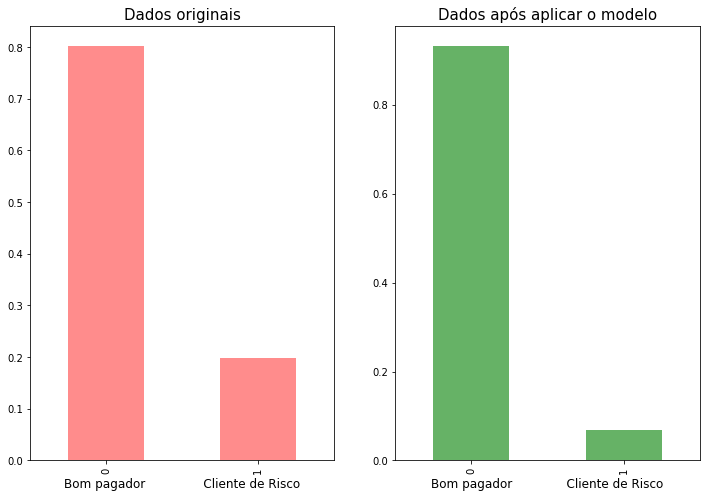

In [103]:
fig,ax=plt.subplots(1,2,figsize=(12,8))

comp_validacao.risco_emprestimo.value_counts(normalize=True).plot(kind='bar',ax=ax[0],color='r',alpha=0.45)
ax[0].set_title('Dados originais',fontsize=15,color='k')
ax[0].set_xlabel('Bom pagador               Cliente de Risco',fontsize=12)

comp_validacao[comp_validacao['previsao']==0].risco_emprestimo.value_counts(normalize=True).plot(kind='bar',ax=ax[1],color='g',alpha=0.6);
ax[1].set_title('Dados após aplicar o modelo',fontsize=15,color='k')
ax[1].set_xlabel('Bom pagador              Cliente de Risco',fontsize=12)

plt.show()

## Conclusão

De acordo com o gráfico acima, apos aplicar o modelo desenvolvido houve uma redução da inadimplência em torno de **14%** 

# Salvando o modelo

In [104]:
import pickle

output = open('best_model_lgbm', 'wb')
pickle.dump(clf, output)
output.close()


# modelo = open('modelo_analise_credito', 'rb')
# new_model = pickle.load(modelo)
# modelo.close()

In [107]:

#  abrindo o arquivo salvo
modelo = open('best_model_lgbm', 'rb')
new_model = pickle.load(modelo)


In [109]:
new_model.predict(X_teste[0:5])

array([0, 0, 0, 0, 1])